Creating another variation on the initial data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("C:..\\Accident_Data_Preprocessing\\Data_Raw\\train_data\\X_train.csv")


## Drop columns unlikely to be useful

Too focused on timing or too fine grained or unique

In [3]:
df.columns

Index(['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City',
       'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [4]:
df.drop(["ID","Source","Country"],axis=1,inplace=True) # drop clearly unneeded columns

In [5]:
df["Zipcode"] = df.Zipcode.apply(lambda x: str(x).split("-")[0]) # fix zipcodes so that they are all 5 digit

In [6]:
df.drop(["End_Time","End_Lat","End_Lng"],axis=1,inplace=True) #can't know these things before it happens

In [7]:
df.drop(["Start_Lat","Start_Lng","State","City"],axis=1,inplace=True)# so much of location data is redundant and correlated

In [8]:
df.drop(["Timezone","Weather_Timestamp","Airport_Code","Description"],axis=1,inplace=True)

In [9]:
df.drop(["Start_Time","Zipcode","County"],axis=1,inplace=True)

## Street Type

In [10]:
df = df[~df.Street.str.contains("Francis Scott Key Bridge",na=False)]

In [11]:
print(df.Street.value_counts().shape)
df.Street.value_counts()

(6916,)


Street
I-95 S                 4606
I-95 N                 4519
Capital Beltway S      3252
Capital Beltway N      2551
Capital Beltway W      2338
                       ... 
Crescent Ave              1
Garrett Morgan Blvd       1
Damascus Manor Rd         1
Michele Dr                1
Weyburn Rd                1
Name: count, Length: 6916, dtype: int64

In [12]:
def nsew(x,r):
    if x[-1] in ["N","S","E","W"]:
        r= r+x[-1]
    return r

In [ ]:
def street_type(x):
    if "Tunl" in x or "Tunnel" in x:
        return "Tunnel"#nsew(x,"Tunnel")
    if "I-" in x:
        return "Interstate"
    if " Dr " in x or " Ave " in x or " Rd " in x or " Xing" in x or " Way " in x:
        return "local"
    if "Beltway" in x:
        return "Beltway"
    if "US-" in x[:4] or "MD-" in x[:4] or "Expy" in x:
        return "Highway"
    if "Hwy" in x or "Fwy" in x or "Highway" in x or "Route" in x or "Connector" in x or "Byp" in x or "Bypass" in x or "Gtwy" in x or "Brg" in x or "Trwy" in x:
        return "Highway"
    if x[-2:] in ["St","Pl","Dr","Sq"]:
        return "local"
    if "Ln" in x or "Rd" in x or "Ct" in x:
        return "local"
    if x[-3:] in ["Way","Cir","Ter","Trl","Plz","Aly","Grn","way","Ext"]:
        return "local"
    if "Ave" in x[-5:] or " Blvd" in x or " Pike" in x or "Pkwy" in x or "Crse" in x or "Alameda" in x:
        return "large_local"
    if "Garth" in x or "Spell" in x or "Psge" in x or "Chase" in x or "Cutoff" in x or "Spire" in x:
        return "local"
    if "Overlook" in x or "Battlefield" in x or "Cemetery" in x or "Park" in x or "Base" in x or "Concourse" in x or "Memorial" in x or "Booth's" in x:
        return "special"
    if "Loop" in x or "Greenway" in x or "West" in x or "ville" in x or "wood" in x:
        return "local"
    
    return x

In [18]:
df["Street"] = df["Street"].astype(str)
df["Street"] = df.Street.apply(street_type)

In [19]:
df=df.loc[~df.Street.str.contains("special")]

In [20]:
df.Street.value_counts()

Street
Interstate        31043
local             27512
large_local       19911
Highway           19602
Beltway           11442
                  ...  
39B                   1
 Olde Mill Run        1
3A                    1
41B-A                 1
13C                   1
Name: count, Length: 119, dtype: int64

## Weather Condition

In [21]:
df["Weather_Condition"].value_counts()

Weather_Condition
Fair                       31016
Cloudy                     14502
Mostly Cloudy              11813
Partly Cloudy               7862
Clear                       7537
                           ...  
Snow / Windy                   1
Heavy Ice Pellets              1
Showers in the Vicinity        1
Squalls / Windy                1
Light Snow Shower              1
Name: count, Length: 71, dtype: int64

In [22]:
df = df.loc[(df.Weather_Condition != "Sand")] # too few values

In [23]:
# missing values count as a float
# change to "unknown" instead. Later we can decide if we want to keep
df["Weather_Condition"] = df["Weather_Condition"].fillna("unknown")

In [24]:
df["Weather_Condition"] = df["Weather_Condition"].apply(lambda x: "None" if "N/A" in x else x)

In [25]:
df["Weather_Condition"]=df["Weather_Condition"].apply(lambda x: "Windy" if "Windy" in x else x)

In [26]:
def mapping_1(x):
    tomap = {"Light Drizzle":"Drizzle",
            "Light Rain with Thunder":"Light Thunderstorms and Rain",
            "Thunder in the Vicinity":"Thunder",
            "Heavy Drizzle":"Rain",
            "Mist":"Fog",
            "Light Freezing Drizzle":"Light Freezing Rain"}
    if x in tomap:
        return tomap[x]
    return x

In [27]:
def mapping_2(x):
    tomap = {"Light Rain Shower":"Drizzle",
             "Light Rain":"Drizzle",
            "Light Ice Pellets":"Ice Pellets",
            "Shallow Fog":"Fog"}
    if x in tomap:
        return tomap[x]
    return x

In [28]:
def mapping_3(x):
    tomap = {"Heavy Ice Pellets":"Ice Pellets",
            "Drizzle and Fog":"Fog",
            "Patches of Fog":"Fog",
            "Heavy Snow":"Snow",
            "Heavy Thunderstorms and Rain":"Thunderstorms",
            "T-Storm":"Thunderstorms",
            "Heavy T-Storm":"Thunderstorms",
            "Thunderstorms and Rain":"Thunderstorms"}
    if x in tomap:
        return tomap[x]
    return x

In [29]:
def mapping_4(x):
    tomap = {"Light Snow Shower":"Snow",
            "Light Snow":"Snow",
            "Light Rain Showers":"Drizzle",
            "Light Thunderstorms and Rain":"Thunderstorms"}
    if x in tomap:
        return tomap[x]
    return x

In [30]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_1)                        

In [31]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_2)

In [32]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_3)

In [33]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_4)

In [34]:
df.Weather_Condition.value_counts()

Weather_Condition
Fair                       31016
unknown                    21527
Cloudy                     14502
Mostly Cloudy              11813
Partly Cloudy               7862
Clear                       7537
Overcast                    4808
Drizzle                     4379
Scattered Clouds            2518
Snow                        1421
Fog                         1277
Rain                        1073
Windy                        823
Wintry Mix                   345
Heavy Rain                   302
Haze                         293
Thunderstorms                259
Light Freezing Rain          114
Thunder                      113
Snow and Sleet                45
None                          34
Ice Pellets                   26
Sleet                         22
Small Hail                    21
Thunderstorm                  21
Light Sleet                   21
Hail                          12
Light Freezing Fog             8
Heavy Sleet                    7
Light Snow and Sleet     

None and Light Sleet have almost no rows will values, drop them.
Light Freezing Fog has 10 rows. Change to Fog.
Leave others for now. Will need to decide if further combinations are necessary.

In [35]:
df = df.loc[(df.Weather_Condition != "None") & (df.Weather_Condition != "Light Sleet")]

In [36]:
df=df.reset_index(drop=True)

In [37]:
df.shape

(112163, 28)

## Wind Direction

In [38]:
# Can decide later whether to keep or remove rows with unknown values
df["Wind_Direction"] = df.Wind_Direction.fillna("unknown")

In [39]:
df.Wind_Direction.value_counts()

Wind_Direction
CALM        17950
unknown     16174
WNW          6548
North        6292
NW           6190
Calm         5960
S            5033
W            5004
NNW          4565
SSW          4122
N            3705
SW           3496
SSE          3221
SE           2933
WSW          2861
NNE          2826
NE           2585
ENE          2386
E            2202
ESE          2098
West         1717
VAR          1655
South        1279
East          810
Variable      551
Name: count, dtype: int64

In [40]:
# Basic cleanup of alternative spellings
def wind_map(x):
    tomap = {"CALM":"Calm","South":"S","West":"W","North":"N","East":"E","VAR":"Variable"}
    if x in tomap:
        return tomap[x]
    return x

In [41]:
# Less fine grained values
def wind_2(x):
    tomap = {"WNW":"NW","NNW":"NW","SSW":"SW","SSE":"SE","WSW":"SW","NNE":"NE","ENE":"NE","ESE":"SE"}
    if x in tomap:
        return tomap[x]
    return x

In [42]:
df["Wind_Direction"] = df.Wind_Direction.apply(wind_map)

In [43]:
df["Wind_Direction"] = df.Wind_Direction.apply(wind_2)

In [44]:
df.Wind_Direction.value_counts()

Wind_Direction
Calm        23910
NW          17303
unknown     16174
SW          10479
N            9997
SE           8252
NE           7797
W            6721
S            6312
E            3012
Variable     2206
Name: count, dtype: int64

## Missing Values: drop columns

In [45]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [46]:
df.shape

(112163, 28)

In [47]:
df.isna().sum()

Distance(mi)                 0
Street                       0
Temperature(F)           12581
Wind_Chill(F)            38146
Humidity(%)              12670
Pressure(in)             11622
Visibility(mi)           22000
Wind_Direction               0
Wind_Speed(mph)          27485
Precipitation(in)        39640
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset             238
Civil_Twilight             238
Nautical_Twilight          238
Astronomical_Twilight      238
dtype: int64

In [48]:
# half of the rows are missing wind chill. Better to just drop the column
df.drop(["Wind_Chill(F)"],axis=1,inplace=True)

In [49]:
# half of the rows are missing precipitation, and weather condition already
# covers that situation more or less. So drop
df.drop(["Precipitation(in)"],axis=1,inplace=True)

<Axes: >

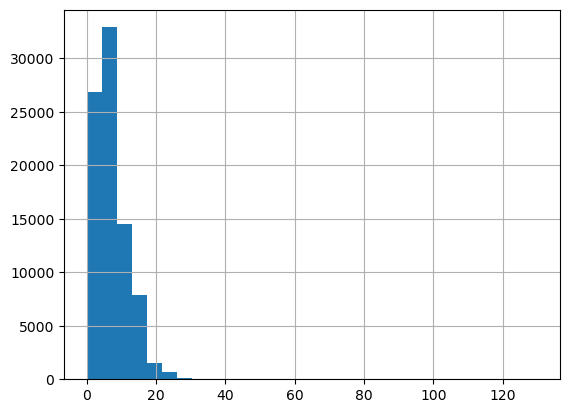

In [50]:
df["Wind_Speed(mph)"].hist(bins=30)

In [51]:
df[df["Wind_Speed(mph)"] > 40].shape[0]

16

Wind speed has a significant number of missing values. It is also a fairly tight distribution other than 11 values that are larger. Although wind speed could be useful in predicting severity, it may not be worth keeping in this situation. I think we try without it first.

In [52]:
df.drop(["Wind_Speed(mph)"],inplace=True,axis=1)

In [53]:
df.isna().sum()

Distance(mi)                 0
Street                       0
Temperature(F)           12581
Humidity(%)              12670
Pressure(in)             11622
Visibility(mi)           22000
Wind_Direction               0
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset             238
Civil_Twilight             238
Nautical_Twilight          238
Astronomical_Twilight      238
dtype: int64

In [54]:
df.dropna().shape

(88904, 25)

It looks like dropping NA values doesn't remove too many rows, there must be rows with multiple NA values. So let's drop NA rows.

In [55]:
df.dropna(inplace=True)

## Twilights

We don't need four different twilights.

In [56]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

In [57]:
df.drop(['Civil_Twilight','Nautical_Twilight', 'Astronomical_Twilight'],inplace=True,axis=1)

## Any columns have too little info?

In [58]:
for col in ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop']:
    print(df[col].value_counts())

Amenity
False    88384
True       520
Name: count, dtype: int64
Bump
False    88889
True        15
Name: count, dtype: int64
Crossing
False    83563
True      5341
Name: count, dtype: int64
Give_Way
False    88671
True       233
Name: count, dtype: int64
Junction
False    78004
True     10900
Name: count, dtype: int64
No_Exit
False    88779
True       125
Name: count, dtype: int64
Railway
False    88716
True       188
Name: count, dtype: int64
Roundabout
False    88903
True         1
Name: count, dtype: int64
Station
False    87921
True       983
Name: count, dtype: int64
Stop
False    87888
True      1016
Name: count, dtype: int64
Traffic_Calming
False    88598
True       306
Name: count, dtype: int64
Traffic_Signal
False    78739
True     10165
Name: count, dtype: int64
Turning_Loop
False    88904
Name: count, dtype: int64


Bump, Give_Way, No_Exit, Roundabout, have almost no True values, so drop.
All values in Turning_Loop are identical, so drop.

In [59]:
df.drop(['Bump', 'Give_Way', 'No_Exit', 'Roundabout','Turning_Loop'],inplace=True,axis=1)

Will need to consider if it is worth keeping all of these or combining in some way.

In [60]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset'],
      dtype='object')

In [61]:
df.shape

(88904, 17)

In [62]:
df.head(50)

,Distance(mi),Street,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset
0,0.346,local,82.0,42.0,29.52,10.0,SW,Fair,False,True,False,False,False,False,False,True,Day
1,0.000,local,75.0,94.0,29.95,9.0,SW,Mostly Cloudy,False,False,False,False,False,False,False,False,Day
2,0.547,Highway,73.0,47.0,29.94,10.0,S,Fair,False,False,False,False,False,False,False,False,Day
3,0.334,Beltway,38.0,67.0,30.10,10.0,N,Partly Cloudy,False,False,True,False,False,False,False,False,Night
7,0.262,Highway,63.0,94.0,30.21,10.0,NE,Cloudy,False,False,False,False,False,False,False,False,Day
8,0.000,local,15.8,53.0,30.56,10.0,W,Clear,False,False,False,False,False,False,False,False,Day
9,0.175,local,55.0,77.0,29.68,10.0,Calm,Mostly Cloudy,False,False,False,False,False,False,False,False,Night
10,0.317,Beltway,64.0,50.0,30.32,10.0,Calm,Cloudy,False,False,False,False,False,False,False,False,Day
11,0.000,local,21.4,43.0,30.74,10.0,Calm,Clear,False,False,False,False,False,False,False,False,Day
12,0.066,Interstate,33.8,52.0,30.17,10.0,NW,Clear,False,False,False,False,False,False,False,False,Night


In [63]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset'],
      dtype='object')

In [64]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(88904, 17)
(79110, 17)


In [67]:
def control_class_merge(df, c1, c2, c3, c4):
    cols = ['Class', 'Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
            'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
            'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
            'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset']
    
    df['Class'] = np.where(df['Severity'] == 1, 1, 0)
    df_c1 = df[df['Class'] != 0]
    df_c0 = df[df['Class'] != 1]
    df_c1 = df_c1.drop_duplicates()
    df_c0 = df_c0.drop_duplicates()
    df_c1.to_csv(f"C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Merge\\control_class{c1}.csv", columns = cols, index = False)
    df_c0.to_csv(f"C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Merge\\control_class{c2}_{c3}_{c4}_merge.csv", columns = cols, index = False)
    
    df['Class'] = np.where(df['Severity'] == 2, 1, 0)
    df_c1 = df[df['Class'] != 0]
    df_c0 = df[df['Class'] != 1]
    df_c1 = df_c1.drop_duplicates()
    df_c0 = df_c0.drop_duplicates()
    df_c1.to_csv(f"C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Merge\\control_class{c2}.csv", columns = cols, index = False)
    df_c0.to_csv(f"C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Merge\\control_class{c1}_{c3}_{c4}_merge.csv", columns = cols, index = False)
    
    df['Class'] = np.where(df['Severity'] == 3, 1, 0)
    df_c1 = df[df['Class'] != 0]
    df_c0 = df[df['Class'] != 1]
    df_c1 = df_c1.drop_duplicates()
    df_c0 = df_c0.drop_duplicates()
    df_c1.to_csv(f"C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Merge\\control_class{c3}.csv", columns = cols, index = False)
    df_c0.to_csv(f"C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Merge\\control_class{c1}_{c2}_{c4}_merge.csv", columns = cols, index = False)
    
    df['Class'] = np.where(df['Severity'] == 4, 1, 0)
    df_c1 = df[df['Class'] != 0]
    df_c0 = df[df['Class'] != 1]
    df_c1 = df_c1.drop_duplicates()
    df_c0 = df_c0.drop_duplicates()
    df_c1.to_csv(f"C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Merge\\control_class{c4}.csv", columns = cols, index = False)
    df_c0.to_csv(f"C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Merge\\control_class{c1}_{c2}_{c3}_merge.csv", columns = cols, index = False)

In [68]:
control_class_merge(df, 1,2,3,4)

KeyError: 'Severity'

In [69]:
df = df.drop(columns='Class')
df = df.rename(columns={'Severity' : 'Class'})
df = df.drop_duplicates()
df.to_csv("C:..\\Accident_Data_Preprocessing\\Data_Cleaned\\control_datasets_unbin\\Control_Class_Unmerge\\control.csv", index = False)

KeyError: "['Class'] not found in axis"